In [1]:
3

3

In [2]:
%load_ext autoreload
%autoreload 2

import pylab as plt
import numpy as np
import torch
import swyft
import swyft.lightning as sl
import lensing_model
from pytorch_lightning import loggers as pl_loggers
from pyrofit.lensing.sources import SersicSource

import sys
sys.path.append('../16-swyft_unet/scripts/')
from plot import *
from unet import UNET
imkwargs = dict(extent=(-2.5, 2.5, -2.5, 2.5), origin='lower') #left, right, bottom, top
from pyrofit.lensing.distributions import get_default_shmf

from tqdm import tqdm
DEVICE = 'cuda'

from predict import Prior, Predict, InferenceQuality

from icecream import install
install()

## Problem-specific analysis components

In [38]:
KNN = 3
SIGMA = 0.00

nsub = NSUB = 4
nmc = NMC = 1
L = 40
low  = LOW = torch.tensor([-2.5, -2.5, 10.], device = DEVICE)
high = HIGH = torch.tensor([ 2.5,  2.5, 11.0], device = DEVICE)

class Model(sl.SwyftModel):
    def __init__(self):
        self.paramtrans = sl.CustomParameterTransform(nsub=NSUB, nmc=NMC, L=L, low=LOW, high=HIGH)
    
    
    def slow(self, pars):
        torch.cuda.set_device(0)
        torch.set_default_tensor_type(torch.cuda.FloatTensor)    
        
#         x, y, phi, q, r_ein, slope = pars['z_lens'] 
        x, y, phi, q, r_ein, slope = -0.05, 0.1, 1., 0.75, 1.5, 2.1 # fix lens parameters for now
    
#         x_src, y_src, phi_src, q_src, index, r_e, I_e = pars['z_src']
        x_src, y_src, phi_src, q_src, index, r_e, I_e = 0., 0., 1., 0.5, 1., 1., 1. # fix source parameters for now
        
#         xy_sub, M_sub, nsub = pars['xy_sub'], pars['M_sub'], pars['nsub']
        z_sub = pars['z_sub'].to(DEVICE)
#         z_sub[:,2] = z_sub[:,2]/1e11

        img, coords = lensing_model.image_generator_toy(x, y, phi, q, r_ein, slope, x_src, y_src, phi_src, q_src, index, r_e, I_e, z_sub)
        X, Y, Xsrc, Ysrc = coords
        kNN_idx = lensing_model.get_kNN_idx(X/5, -Y/5, Xsrc, Ysrc, k = KNN)  # TODO: Need to sort out strange 1/5 and -1/5 factors
        torch.set_default_tensor_type(torch.FloatTensor)
        return sl.SampleStore(mu = img.cpu())
    
    def fast(self, d):
        img = d['mu'] + torch.randn_like(d['mu'])*SIGMA
        return sl.SampleStore(img=img)
    
    def prior(self, N, bounds = None):
#         src_samples  = self.prior_sersic(N, bounds = bounds)
#         lens_samples = self.prior_lens(N, bounds = bounds)
        sub_samples  = self.prior_sub(N, bounds = bounds)
        return sl.SampleStore(**sub_samples)
    
    def prior_sersic(self, N, bounds = None):
        if bounds is not None:
            low = bounds['z_src'].low
            high = bounds['z_src'].high
        else:
            low =  np.array([-0.1, -0.1, 0, 0., 0.5, 0.1, 0.])
            high = np.array([0.1, 0.1, 1.5, 1., 4.0, 2.5, 4.])
        draw = np.array([np.random.uniform(low=low, high=high) for _ in range(N)])
        return sl.SampleStore(z_src = torch.tensor(draw).float())

    def prior_lens(self, N, bounds = None):
        if bounds is not None:
            low = bounds['z_lens'].low
            high = bounds['z_lens'].high
        else:
            low =  np.array([-0.2, -0.2, 0, 0.2, 1.0, 1.5])
            high = np.array([0.2, 0.2, 1.5, 0.9, 2.0, 2.5])
        draw = np.array([np.random.uniform(low=low, high=high) for _ in range(N)])
        return sl.SampleStore(z_lens = torch.tensor(draw).float())
    
    def prior_sub(self, N, bounds = None):
        nsub  = NSUB
        z_lens = 0.5
        
        if bounds is not None:
            low = bounds['z_lens'].low
            high = bounds['z_lens'].high
        else:
            low  = torch.tensor([-2.5, -2.5, 10.])
            high = torch.tensor([ 2.5,  2.5, 11.])
        
        xy_dist = torch.distributions.Uniform(low[[0, 1]], high[[0, 1]])
        M_dist  = get_default_shmf(z_lens = z_lens, log_range = (low[2], high[2]))
        
        xy_sub = xy_dist.sample((N, nsub))
        M_sub = M_dist.sample((N, nsub, 1))
        
        
        z_sub = torch.cat((xy_sub, M_sub), dim = 2)
        
        z_pix = self.paramtrans(z_sub.to(DEVICE)).cpu()
        
#         return sl.SampleStore(z_sub=z_sub, z_pix = z_pix)
        return sl.SampleStore(z_sub=z_sub)

    
m = Model();
s_examples = m.sample(5)

100%|██████████| 5/5 [00:00<00:00, 3312.51it/s]


In [39]:
s_examples['z_sub'].shape

torch.Size([5, 4, 3])

In [35]:
s_examples['img'].shape

torch.Size([4, 40, 40])

100%|██████████| 4/4 [00:00<00:00, 10824.01it/s]


TypeError: Invalid shape (1, 40, 40) for image data

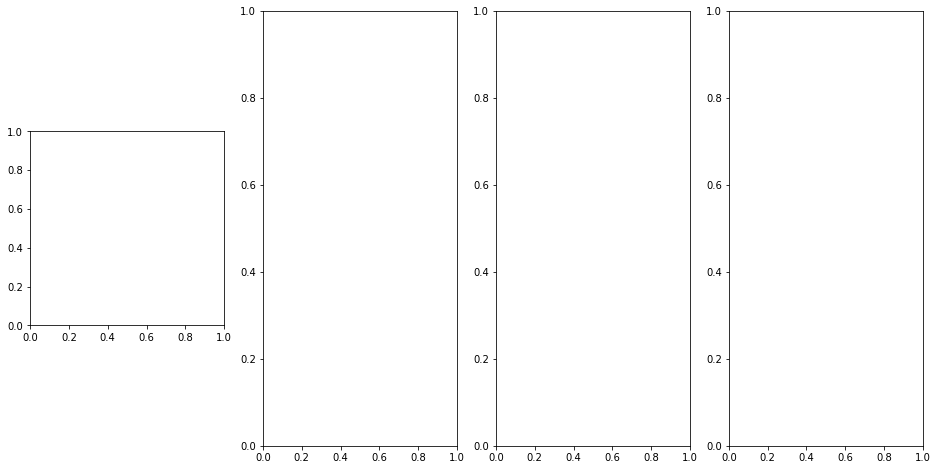

In [30]:
s_examples = m.sample(4)
plt_imshow( s_examples['img'],
           scatter = s_examples['z_sub'],
           cbar = True, **imkwargs )

In [5]:
paramtrans = sl.CustomParameterTransform(nsub, nmc, L, low, high)

100%|██████████| 1/1 [00:00<00:00, 3927.25it/s]


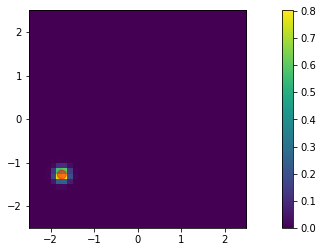

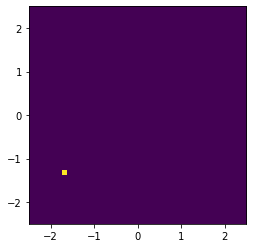

In [6]:
s0 = m.sample(1)
plt_imshow( s0['img'], circles = s0['z_sub'], cbar = True, **imkwargs , y = 4)
plt_imshow( paramtrans(s0['z_sub'].to(DEVICE)).squeeze(0).cpu(), **imkwargs, y = 4)

In [7]:
class SubNetwork(sl.SwyftModule):
    def __init__(self):
        super().__init__()
        
        nmc = NMC
        
        self.online_z_score = swyft.networks.OnlineDictStandardizingLayer(dict(img = (L, L)))
        self.c = sl.RatioEstimatorImageSegmentation(nsub=nsub, nmc=nmc, L=L, low=low, high=high)
        
    def forward(self, x, z):
        x = dict(img = x['img'])
        x = self.online_z_score(x)['img']
                
        out = self.c(x, z['z_sub'])
        return dict(z_pix = out)
    
Ntrain1, R1, ME = 5000, 1, 10 # Number of training simulations, number of training rounds (?), max epochs 
# Ntrain1, R1, ME = 500, 1, 2 # Number of training simulations, number of training rounds (?), max epochs 
TARGET = 1
batch_size = 128
tag = 'sub_v5000'

bounds = None
s00 = s0[0]
results = []
for i in range(R1):
    tbl = pl_loggers.TensorBoardLogger("lightning_logs", name = 'lensing_%s'%tag)#, default_hp_metric=True)
    # s1: img, lens, src ~ p(img|lens, src)p(lens)p(src)
    s1 = sl.file_cache(lambda: m.sample(Ntrain1, bounds = bounds), './train_data_%s_%i_%i_%i.pt'%(tag, TARGET, Ntrain1, i))
    
    # r1: p(z_lens|img)/p(z_lens)
    r1 = SubNetwork()
    
    # d1: split img vs z_lens
    # TODO: Specify x_keys = ['img'], z_keys=['z_lens']
    d1 = sl.SwyftDataModule(store = s1, model = m, batch_size = batch_size)
    
    # Train r1 with d1
    t1 = sl.SwyftTrainer(accelerator = 'gpu', gpus=1, max_epochs = ME, logger = tbl)
    t1.fit(r1, d1)
    t1.test(r1, d1)
    
    inferqual = InferenceQuality(r1, d1, nsub, nmc, L, low, high)
    
    alpha_edges, alpha_centers = inferqual.alpha_edges.cpu(), inferqual.alpha_centers.cpu()
    reli_curve = inferqual.get_relicurve().detach().cpu()
    post_sum = inferqual.get_post_sum().cpu().detach().numpy()
    hist = inferqual.get_histogram().cpu().detach().numpy()


    fig = plt.figure(dpi = 200)
    plt.step(alpha_centers, reli_curve)
    plt.plot((0, 1), (0, 1), 'k:')
    tbl.experiment.add_figure("reli_curve", fig)

    fig = plt.figure(dpi = 200)
    plt.stairs(hist, alpha_edges, fill=True)
    plt.yscale('log')
    tbl.experiment.add_figure("post_all_hist_log", fig)

    fig = plt.figure(dpi = 500)
    hist, _, _ = plt.hist(post_sum, bins = 50)
    plt.plot((nmc, nmc), (0, hist.max()), 'k:')
    tbl.experiment.add_figure("post_sum_hist", fig)



    

    
    
    # p1: z_lens ~ p(z_lens|img_obs)  --  these are weighted samples
#     p1 = t1.infer(r1, d1)
    
    

        
#     bounds = None #sl.get_1d_rect_bounds(all_inference, th = 1e-6)  # for p(z_lens)
#     results.append(dict(p1=p1, bounds = bounds))
    

100%|██████████| 5000/5000 [00:00<00:00, 33191.71it/s]
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Missing logger folder: lightning_logs/lensing_sub_v5000
Set SLURM handle signals.

  | Name           | Type                            | Params
-------------------------------------------------------------------
0 | online_z_score | OnlineDictStandardizingLayer    | 0     
1 | c              | RatioEstimatorImageSegmentation | 31.0 M
-------------------------------------------------------------------
31.0 M    Trainable params
0         Non-trainable params
31.0 M    Total params
124.146   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/home/eliasd/.pyenv/versions/3.9.7/envs/lens-3.9.7/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/eliasd/.pyenv/versions/3.9.7/envs/lens-3.9.7/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
/home/eliasd/.pyenv/versions/3.9.7/envs/lens-3.9.7/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `D

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eliasd/.pyenv/versions/3.9.7/envs/lens-3.9.7/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'hp/JS-div': 2216.7060546875, 'hp/KL-div': -9.078481674194336}
--------------------------------------------------------------------------------
Prior subhalo in Mass range
6.25e-04 	 [1.00e+10 - 9.99999980e+10]


100%|██████████| 40/40 [02:15<00:00,  3.39s/it]


In [ ]:
inferqual = InferenceQuality(r1, d1, nsub, nmc, L, low, high)

In [ ]:
alpha_edges, alpha_centers = inferqual.alpha_edges.cpu(), inferqual.alpha_centers.cpu()
reli_curve = inferqual.get_relicurve().detach().cpu()
post_sum = inferqual.get_post_sum().cpu().detach().numpy()
hist = inferqual.get_histogram().cpu().detach().numpy()


In [3]:
import torch

In [15]:
a = torch.tensor((3., 3.), requires_grad=False)
a.detach()

tensor([3., 3.])

In [ ]:
fig = plt.figure(dpi = 200)
plt.step(alpha_centers, reli_curve)
plt.plot((0, 1), (0, 1), 'k:')
tbl.experiment.add_figure("reli_curve", fig)

fig = plt.figure(dpi = 200)
plt.hist(post_sum, density = True)
plt.plot((nmc, nmc), (0, 1), 'k:')
tbl.experiment.add_figure("post_sum_hist", fig)

fig = plt.figure(dpi = 200)
plt.stairs(hist, alpha_edges, fill=True)
tbl.experiment.add_figure("post_all_hist", fig)

In [ ]:
reli_curve, alpha_edges, alpha_centers = inferqual.get_relicurve()
#     post_sum = inferqual.get_post_sum()

In [ ]:
assert 1 == 2

In [ ]:
plt.stairs(hist.detach().numpy(), bin_edges.detach().numpy(), fill=True)

In [ ]:
hist, bin_edges = torch.histogram(inferqual.posts.flatten().cpu(), bins = alpha_edges.cpu())

In [ ]:
assert 1 == 2

In [ ]:
relicurve = ReliCurve(r1, d1, nsub, nmc, L, low, high)
reli_curve, alpha_edges, alpha_centers = relicurve(max_n_test = 5000)

In [ ]:
d1.batch_size

In [ ]:
len(dataset[0])

In [ ]:
predict = Predict(nsub, nmc, L, low, high)

In [ ]:
posts = []
for s_batch in tqdm(d1.test_dataloader()):
    posts.append(  predict(r1, s_batch[0]) )
posts = torch.cat(posts)

In [ ]:
pp = 0
for p in posts:
    pp += len(p)
print(pp)

In [ ]:
max_n_test = 10_000


In [ ]:
list(self.test_dataloader)

In [ ]:
d1_list = list(d1.test_dataloader()) 

In [ ]:
len(d1_list)

In [ ]:
d1_listlist  = d1_list[0]
len(d1_listlist)

In [ ]:
d1_listlist[0].keys()

In [ ]:
(d1_listlist[0]['img'] == d1_listlist[1]['img']).all()

In [ ]:
relicurve = ReliCurve(r1, d1, nsub, nmc, L, low, high)

In [ ]:
reli_curve, alpha_edges, alpha_centers = relicurve(test_batch_size = 1)

In [ ]:
40*128

In [ ]:
i = 0
for _ in iter(d1.test_dataloader()):
    i +=1
print(i)

In [ ]:
list(d1.test_dataloader())[0][1]['img'].shape

In [ ]:
list(d1.test_dataloader())[0][0]['img'].shape

In [ ]:
test_n_batches = len(list(relicurve.test_dataloader)) // 32

In [ ]:
test_n_batches

In [ ]:
assert 1 ==2 

In [ ]:
dataset = d1.test_dataloader()

In [ ]:
i = 0
for _ in next(iter(dataset)):
    i +=1
print(i)

In [ ]:
posts, targets = relicurve.get_predictions(500)

In [ ]:
posts.shape

In [ ]:
plt.hist(torch.sum(posts, axis = (1, 2, 3)).detach().cpu().numpy() )

In [ ]:
class ReliabilityCurve():
    def __init__(self, r1, d1, nsub, nmc, L, low, high):
        self.r1 = r1
        self.d1 = d1
        
        self.test_dataloader = d1.test_dataloader()
        
        self.predict = Predict(nsub, nmc, L, low, high)
        
    def get_predictions(self, test_batch_size = 32):
        test_n_batches = len(list(self.test_dataloader)) // test_batch_size
        posts, targets = [], []
        for _, s_batch in tqdm(zip(range(test_n_batches), self.test_dataloader), total = test_n_batches):
            posts.append(  self.predict(self.r1, s_batch[0]) )
            targets.append( self.r1.c.paramtrans(s_batch[0]['z_sub'].to(DEVICE)) )
        posts = torch.cat(posts)
        targets = torch.cat(targets)
        return posts, targets
    
    def get_alpha(self, n_alpha = 50):
        alpha_edges = torch.linspace(0, 1, n_alpha, device = DEVICE, dtype=torch.float64)
        alpha_centers = (alpha_edges[:-1] + alpha_edges[1:])/2
        return alpha_edges, alpha_centers
    
    def __call__(self, n_alpha = 50, test_batch_size = 32):
        alpha_edges, alpha_centers = self.get_alpha(n_alpha)
        posts, targets = self.get_predictions(test_batch_size)
        
        posts_alpha = torch.repeat_interleave(posts.unsqueeze(-1), n_alpha-1, dim = -1)
        targets_alpha = torch.repeat_interleave(targets.unsqueeze(-1), n_alpha-1, dim = -1)
        
        is_between = (posts_alpha > alpha_edges[:-1]) & (posts_alpha < alpha_edges[1:])
        is_between_sum = torch.sum(targets_alpha * is_between, dim = (0, 1, 2, 3))
        hist = torch.histogram(posts.flatten().cpu(), bins = alpha_edges.cpu())[0].to(DEVICE) #torch.histogram doesn't work on cuda 
        reli_curve = is_between_sum/hist
        
        return reli_curve, alpha_edges, alpha_centers

ReliCurve = ReliabilityCurve(r1, d1, nsub, nmc, L, low, high)
reli_curve, alpha_edges, alpha_centers = ReliCurve(n_alpha = 50)

In [ ]:
n_alpha = 50
alpha_edges = torch.linspace(0, 1, n_alpha, device = DEVICE, dtype=torch.float64)
alpha_centers = (alpha_edges[:-1] + alpha_edges[1:])/2

In [ ]:
prior = ReliCurve.predict.prior

In [ ]:
posts_alpha = torch.repeat_interleave(posts.unsqueeze(-1), n_alpha-1, dim = -1)
targets_alpha = torch.repeat_interleave(targets.unsqueeze(-1), n_alpha-1, dim = -1)

In [ ]:
is_between = (posts_alpha > alpha_edges[:-1]) & (posts_alpha < alpha_edges[1:])

In [ ]:
is_between_sum = torch.sum(targets_alpha * is_between, dim = (0, 1, 2, 3))

In [ ]:
hist = torch.histogram(posts.flatten().cpu(), bins = alpha_edges.cpu())[0].to(DEVICE) #torch.histogram doesn't work on cuda 

In [ ]:
reli_curve = is_between_sum/hist

In [ ]:
plt.step(alpha_centers.cpu(), reli_curve.detach().cpu())
plt.plot((0, 1), (0, 1), 'k:')

In [ ]:
def get_target_coords(r1, s1):
    x, y = s1['z_sub'][:,:,[0,1]].squeeze().T
    target = r1.c.paramtrans(s1['z_sub'].to(DEVICE)).cpu().squeeze()
    m_i = torch.stack(torch.where(target == 1))[0]
    target_coords = torch.stack((m_i, x, y)).T
    return target_coords

In [ ]:
s1 = m.sample(100)

In [ ]:
pred = predict(r1, s1).cpu().detach().numpy()

In [ ]:
plt.hist(np.sum(pred, axis = (1, 2, 3)) )

In [31]:
list(d1.test_dataloader())[0][0]['img'][0]

tensor([[1.5248e-11, 2.2683e-11, 3.2303e-11,  ..., 8.7766e-18, 2.5977e-18,
         7.3604e-19],
        [6.1327e-11, 9.1232e-11, 1.2992e-10,  ..., 3.5299e-17, 1.0448e-17,
         2.9603e-18],
        [2.3612e-10, 3.5126e-10, 5.0023e-10,  ..., 1.3591e-16, 4.0226e-17,
         1.1398e-17],
        ...,
        [8.4194e-02, 1.2525e-01, 1.7837e-01,  ..., 4.8461e-08, 1.4343e-08,
         4.0641e-09],
        [6.7373e-02, 1.0023e-01, 1.4273e-01,  ..., 3.8779e-08, 1.1478e-08,
         3.2522e-09],
        [5.1611e-02, 7.6778e-02, 1.0934e-01,  ..., 2.9707e-08, 8.7926e-09,
         2.4913e-09]])

In [39]:
idx = np.random.randint(10)
post, target = inferqual.posts[idx].cpu().detach().numpy(), inferqual.targets[idx].cpu().detach().numpy()

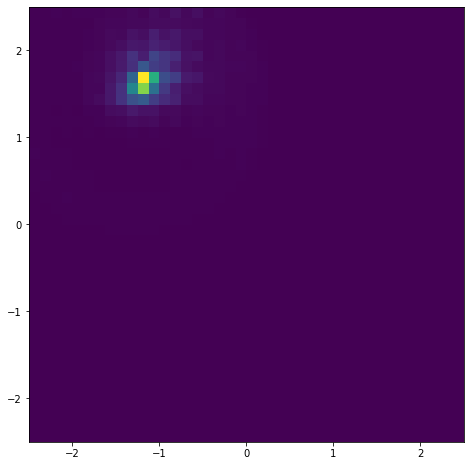

In [41]:
plt_imshow(post, **imkwargs)

In [ ]:
s1 = m.sample(1)

pred = predict(r1, s1).cpu().detach().numpy()

plt.imshow(s1['img'].squeeze(), **imkwargs)

plt_imshow(pred.squeeze(0), cbar = True,
#            zlog = True,
#            target_coords=get_target_coords(r1, s1),
           title = fr"$\sum_{{ijk}} \, p(\theta|x_{{ijk}})= {np.sum(pred):.2f}$",
           supx = 0.25, supy = 1.0, supsize = 20,
           **imkwargs, y = 4, 
           priors = prior
          ) 

In [ ]:
# grid = torch.linspace(low[0], high[0], L+1)[:-1]
# x, y = torch.meshgrid(grid, grid, indexing = 'xy')
# ms = [torch.full((x.shape), m_i) for m_i in m_edges[:-1]]

# z_sub_all   = torch.cat([ torch.stack((x, y, m), dim = 2).flatten(end_dim = 1) for m in ms]).unsqueeze(0).to(DEVICE)
# z_sub_empty = torch.tensor((), device = DEVICE, dtype = torch.float).reshape(1, 0, 3).to(DEVICE)

# z_sub_all = dict(z_sub = z_sub_all)
# z_sub_empty = dict(z_sub = z_sub_empty)

In [ ]:
# s1 = m.sample(1)

# logratios_all = []
# for _ in range(100):
#     logratios = torch.zeros((nmc*2, L, L), device = DEVICE)
#     logratios[:nmc] = r1(s1, z_sub_empty)['z_pix'].ratios.squeeze()
#     logratios[nmc:] = r1(s1, z_sub_all)['z_pix'].ratios.squeeze()
#     logratios_all.append(logratios)
# logratios_all = torch.stack(logratios_all)

# plt.plot( torch.mean(logratios_all[:-1] - logratios_all[1:], dim = (1, 2, 3)).cpu().detach() )

In [ ]:
# s00 = s0.copy()
# for k, v in s00.items():
#     s00[k] = v.unsqueeze(0)

In [ ]:
assert 1 == 2

In [ ]:
# logratios = torch.zeros((nmc*2, L, L), device = DEVICE)
# logratios[:nmc] = r1(s1, z_sub_empty)['z_pix'].ratios.squeeze()
# logratios[nmc:] = r1(s1, z_sub_all)['z_pix'].ratios.squeeze()

# logratios2 = torch.zeros((nmc*2, L, L), device = DEVICE)
# logratios2[:nmc] = r1(s1, z_sub_empty)['z_pix'].ratios.squeeze()
# logratios2[nmc:] = r1(s1, z_sub_all)['z_pix'].ratios.squeeze()




In [ ]:
post_sum = torch.sum(torch.transpose( posts.reshape(2, nmc, L, L), 0, 1), dim = 1)
post_norm = posts[nmc:] / post_sum
plt_imshow( post_norm.cpu().detach().numpy() , cbar = True, **imkwargs)

In [ ]:
plt_imshow( priors[nmc:].cpu().detach().numpy(), cbar = True, **imkwargs)

In [ ]:
plt_imshow(paramtrans(predict.z_sub_all['z_sub']).squeeze().cpu(), cbar = True, y = 4)

In [ ]:
plt_imshow(paramtrans(predict.z_sub_empty['z_sub']).squeeze().cpu(), cbar = True, y = 4)

In [ ]:
prior = Prior(nsub, nmc, L, low, high)

In [ ]:
prior.calc_prior()

In [ ]:
assert 1==2

In [ ]:
priors.shape

In [ ]:
plt_imshow(priors , cbar = True, tl = True)

In [ ]:
logratios = p1['z_pix'].ratios

In [ ]:
logratios.shape

In [ ]:
plt_imshow( s0['img'].unsqueeze(0),
           scatter = s0['z_sub'].unsqueeze(0),
           cbar = True,
           **imkwargs )

In [ ]:
plt_imshow( (torch.mean(logratios, dim = 0) ), cbar = True, **imkwargs)

In [ ]:
plt_imshow( torch.exp(torch.mean(logratios, dim = 0)), cbar = True)

In [ ]:
rand_int = torch.randint(high = Ntrain1, size = (5,))
for ratios, values in zip(p1['z_pix'].ratios[[rand_int]], p1['z_pix'].values[[rand_int]]):
    plt_imshow(ratios, 
               scatter = torch.stack((values, values, values)),
               **imkwargs, cbar = True)
    plt_imshow(ratios, 
#                scatter = torch.stack((values, values, values)),
               **imkwargs, cbar = True)
    plt_imshow( paramtrans(values.unsqueeze(0).to(DEVICE)).squeeze()[:nmc].cpu(), **imkwargs )